In [1]:
import sys
sys.path.append('../')
import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.pure_fit_model as pure_fit_model

import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
class general_EPIs_dense(torch.nn.Module):
    def __init__(self, contact, psMatrices, crossImmMatrix, Ts, train=False, sampleAsState=False, device="cpu"):
        super(general_EPIs_dense, self).__init__()
        self._n= contact.size()[1]
        self._k= psMatrices.size()[0]
        self._contact= contact
        self._psMatrices= psMatrices
        self._crossImmMatrix= crossImmMatrix
        self._train= train
        self._device= device
        self._sampleAsState= sampleAsState
        self._Linear= self.encode_linear()
        self._Ts= Ts
        self._mySig = torch.nn.Sigmoid()
        if train==True:
            self._Linear=torch.nn.Parameter(self._Linear)
            self._Ts= torch.nn.Parameter(self._Ts)
        self._init_mask_T()
    def forward(self, state, t): # state shape:(K, n, 4, 1)
        cL= self._mySig(1000*(t-self._Ts))
        cL= cL[..., None, None]
        cL= cL*self._controlMask+self._controlI
        cL= cL[None, :, None, ..., None]
        linear= self._Linear*cL
        A= linear.matmul(state[:, None, :, None, ...])
        Psts= torch.prod(A, dim=0)
        Psts= Psts.squeeze()
        sumPsts= Psts.sum(dim= -2)+ 1e-8
        sumPsts= sumPsts[:, :, None, :]
        Psts= Psts/sumPsts
        Psts2= Psts[:, :, 1, 0]
        s= state[:, :, 0:1, 0]
        i= state[:, :, 2:3, 0]
        s= s.permute(0, 2, 1)
        Temp= self._contact*i*s
        Psts2= 1-Temp*Psts2 [..., None]
        Psts2= 1-torch.prod(Psts2, dim=-2)
        Psts[:, :, 1, 0]= Psts2
        Psts[:, :, 0, 0]= 1- Psts2
        state= state.squeeze()
        newState= Psts.matmul(state[..., None])# new state shape:(K, n, 4, 1)
        return newState
        
    def _init_mask_T(self):
        self._mask1= torch.tensor([ [0, 0, 0, 0],
                                    [0, 1, 1, 0],
                                    [0, 0, 1, 1],
                                    [0, 0, 0, 1]], device=self._device) 
        self._mask2= torch.tensor([ [0, 1, 0, 0],
                                    [0, 0, 0, 0],
                                    [0, 0, 0, 0],
                                    [0, 0, 0, 0]], device=self._device) 
        self._T    = torch.tensor([ [0, 0, 0, 0],
                                    [1, 0, 0, 0],
                                    [0, 0, 0, 0],
                                    [0, 0, 0, 0]], device=self._device) 
        self._mask1= self._mask1[None, ..., None]
        self._controlMask= torch.tensor([   [0, 1, 1, 1],
                                            [1, 0, 1, 1],
                                            [1, 1, 0, 1],
                                            [1, 1, 1, 0]], device=self._device)
        self._controlI= torch.stack([1-self._controlMask]*self._k)
    def encode_linear(self):
        ts= 4
        linear= torch.ones(self._k, self._k, 1, ts, ts, ts, device=self._device)
        for i in range(self._k): # k layer
            for j in range(self._k):# prod layer
                if i==j: #load paMatrices
                    for k in range(ts):
                        linear[j, i, 0, :, :, k]= self._psMatrices[i, ...].T
                else: #load crossImmMatrix
                    linear[j, i, 0, 1, 0, 2:4]= self._crossImmMatrix[j, i]
        return linear


In [27]:
def sim(timeHorizon, model: general_EPIs_dense, state, device="cpu"):
    stateHistory=[]
    staticSI=[]
    for t in range(timeHorizon):
        state= model(state, t)
        stateHistory.append(state.sum(dim=1))
        prob0= 1-state[0, :, 2, 0]
        prob1= 1-state[1, :, 2, 0]
        prob2= 1-state[2, :, 2, 0]
        statisticI= 1-prob0*prob1*prob2
        staticSI.append(statisticI.sum().item())
    stateHistory= torch.stack(stateHistory)
    return stateHistory, staticSI

def init_first_cases(state:torch.tensor):
    kn= state.shape[0]
    for i in range(kn):
        firstInfected= random.randint(0, n-1)
        state[i, firstInfected, 2, 0]= 1 #go to hidden layer
        state[i, firstInfected, 0, 0]= 0

ps=  torch.tensor([[0.75, 0.25, 0, 0],
                    [0, 0.6, 0.4, 0],
                    [0, 0, 0.8, 0.2],
                    [0, 0, 0, 1]], device=device)
psMtrices= torch.stack([ps, ps, ps])
crossImmMatrix= torch.tensor([[0, 0.5, 0.5],
                              [0.5, 0, 0.5],
                              [0.5, 0.5, 0]], device=device)
n= 1000
avgDegree= 6
timeHorizon= 1000
Kn= 3 
state= create_population.general_populations(Kn, n, device=device)# 3, 1000, 4, 1
Ts=  torch.tensor([100, 400, 600], device=device)
init_first_cases(state)
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
contact= contact[None, ...]
inferenceModel= general_EPIs_dense(contact, psMtrices, crossImmMatrix, Ts, device=device)
with torch.no_grad():
    stateHistory, statisticI= sim(timeHorizon, inferenceModel, state, device=device)
stateHistoryPlot= stateHistory.cpu().detach()

1000


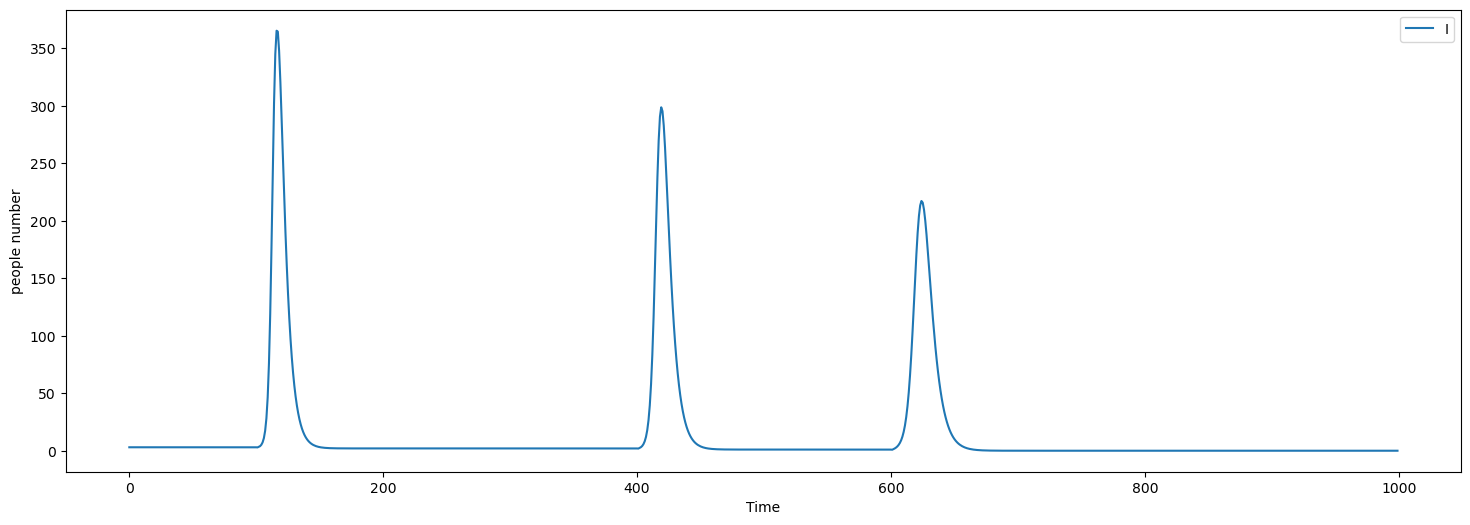

In [29]:
stateHistoryPlot0= stateHistoryPlot[:, 0, :, 0]
stateHistoryPlot1= stateHistoryPlot[:, 1, :, 0]
stateHistoryPlot2= stateHistoryPlot[:, 2, :, 0]

plt.figure(figsize=(18,6))
# plt.plot(stateHistoryPlot0, label=["s0", "e0", "i0", "r0"])
# plt.plot(stateHistoryPlot1, label=["s1", "e1", "i1", "r1"])
# plt.plot(stateHistoryPlot2, label=["s2", "e2", "i2", "r2"])
# for i, _ in enumerate(staticSI):
#     staticSI[i]= i*staticSI[i]
plt.plot(statisticI, label="I")
print(len(statisticI))
plt.xlabel("Time")
#plt.ylabel("Infectiveness number")
plt.ylabel("people number")
plt.legend()